In [1]:
import numpy as np
import pandas as pd
from easypreprocessing import EasyPreProcessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost

Easydataframerocessing is a library used for common ML related dataframerocessing activities.

In [2]:
dataframe = EasyPreProcessing('data.csv')


**Initialization Parameters**

1.  output            - Set output variable/dependent variable
2.  dates.features    - Set datetime field names (optional)

For example:
1.  output = 'column_name'
2.  dates.features = ['date_field_1','date_field_2']
        

# Handling Null Values

In [3]:
dataframe.categorical.fields

['week']

In [4]:
dataframe.numerical.fields

['record_ID',
 'store_id',
 'sku_id',
 'total_price',
 'base_price',
 'is_featured_sku',
 'is_display_sku',
 'units_sold']

In [5]:
dataframe.missing_values

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [6]:
dataframe.numerical.impute()

Numerical features imputated successfully.


In [7]:
dataframe.df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1.0,17/01/11,8091.0,216418.0,99.0375,111.8625,0.0,0.0,20.0
1,2.0,17/01/11,8091.0,216419.0,99.0375,99.0375,0.0,0.0,28.0
2,3.0,17/01/11,8091.0,216425.0,133.9500,133.9500,0.0,0.0,19.0
3,4.0,17/01/11,8091.0,216233.0,133.9500,133.9500,0.0,0.0,44.0
4,5.0,17/01/11,8091.0,217390.0,141.0750,141.0750,0.0,0.0,52.0
...,...,...,...,...,...,...,...,...,...
150145,212638.0,09/07/13,9984.0,223245.0,235.8375,235.8375,0.0,0.0,38.0
150146,212639.0,09/07/13,9984.0,223153.0,235.8375,235.8375,0.0,0.0,30.0
150147,212642.0,09/07/13,9984.0,245338.0,357.6750,483.7875,1.0,1.0,31.0
150148,212643.0,09/07/13,9984.0,547934.0,141.7875,191.6625,0.0,1.0,12.0


A new column 'key' createdfor unique identification. This is done in order to handle the duplicate data in 'week' column.

In [8]:
dataframe.dataset['key'] = dataframe.df['week'].astype(str) + '_' + dataframe.df['store_id'].astype(str) 

Removing columns that are not helpful for time series predictions.

In [9]:
dataframe.dataset = dataframe.df.drop(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku'], axis=1)

Summing units_sold group by key.

In [10]:
dataframe.dataset = dataframe.df.groupby('key').sum()

In [11]:
dataframe.df

,units_sold
key,
01/01/13_8023.0,2025.0
01/01/13_8058.0,682.0
01/01/13_8063.0,535.0
01/01/13_8091.0,210.0
01/01/13_8094.0,782.0
...,...
31/10/11_9890.0,531.0
31/10/11_9909.0,551.0
31/10/11_9954.0,431.0


<AxesSubplot:xlabel='key'>

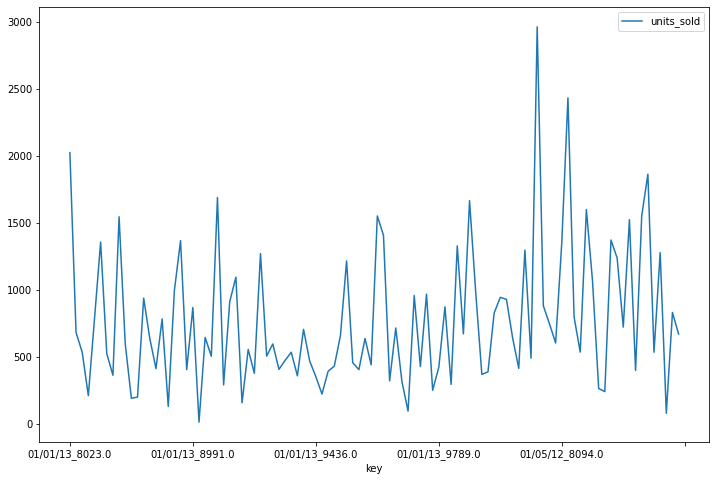

In [12]:
dataframe.df[:100].plot(figsize=(12,8))

# Converting supervised dataset

```units_sold``` becomes target variable

```day_1```, ```day_2```, ```day_3```, ```day_4``` becomes input

We will train our model to predict sales based on previous 4 days.

In [15]:
dataframe.df['day_1'] = dataframe.df['units_sold'].shift(-1)
dataframe.df['day_2'] = dataframe.df['units_sold'].shift(-2)
dataframe.df['day_3'] = dataframe.df['units_sold'].shift(-3)
dataframe.df['day_4'] = dataframe.df['units_sold'].shift(-4)

Remove NA data

In [16]:
df = dataframe.df.dropna()

<AxesSubplot:xlabel='key'>

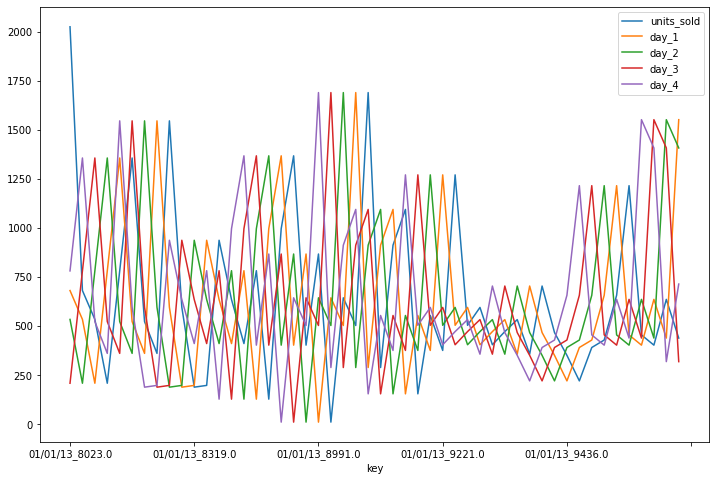

In [17]:
df[:50].plot(figsize=(12,8))

# Train-Test Split

In [18]:
x1, x2, x3, x4, y = df['day_1'], df['day_2'], df['day_3'], df['day_4'], df['units_sold']
x1, x2, x3, x4, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(y)
x1, x2, x3, x4, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(df)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8395, 4)
(1481, 4)
(8395, 1)
(1481, 1)


# Random Forest Regression

In [20]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

C:\Users\Noopur\AppData\Local\Temp\ipykernel_11996\4137761455.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(X_train, y_train)


In [21]:
print("R Sq. Score for Random Forest Regression :", rf_regressor.score(X_test, y_test))

R Sq. Score for Random Forest Regression : 0.6792094998987421


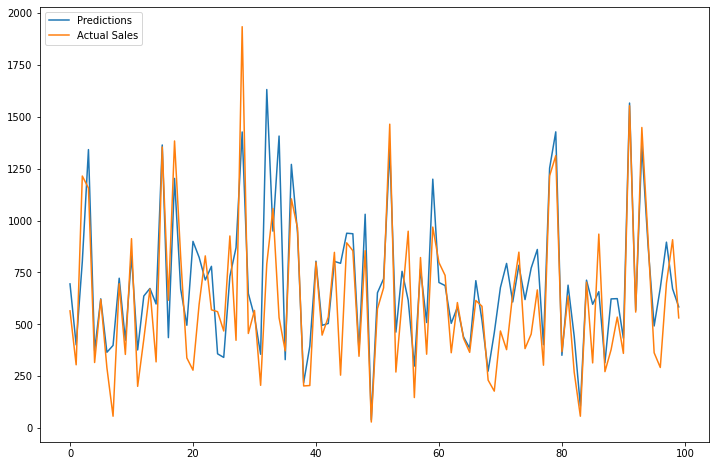

In [22]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# XGBoost Regression

In [23]:
xgb_regressor = xgboost.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

In [24]:
print("R Sq. Score for XGBoost :", xgb_regressor.score(X_test, y_test))

R Sq. Score for XGBoost : 0.5560478646422438


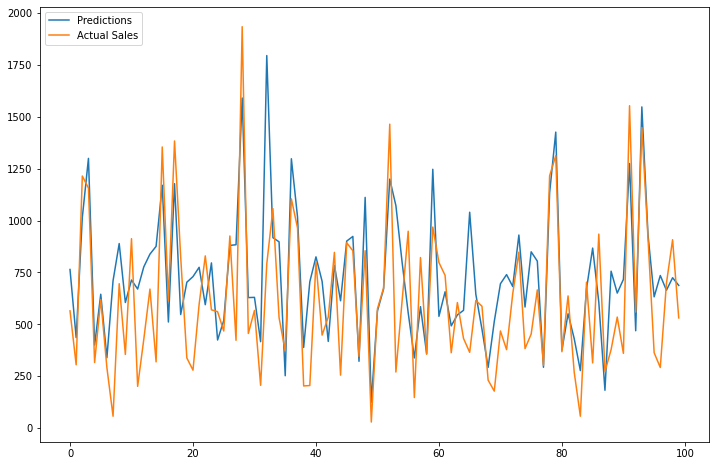

In [25]:
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# Hyperparameter Tuning for Random Forest

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [30]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [31]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Noopur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\Noopur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 116,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 56,
 'bootstrap': True}

In [33]:
best_random = rf_random.best_estimator_

In [34]:
y_pred = best_random.predict(X_test)

In [35]:
print("R Sq. Score for Random Forest Regression :", best_random.score(X_test, y_test))
print("Adj. R Sq. Score for Random Forest Regression :", 1 - (1 - best_random.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 ))

R Sq. Score for Random Forest Regression : 0.6859648031422891
Adj. R Sq. Score for Random Forest Regression : 0.6851137592483658


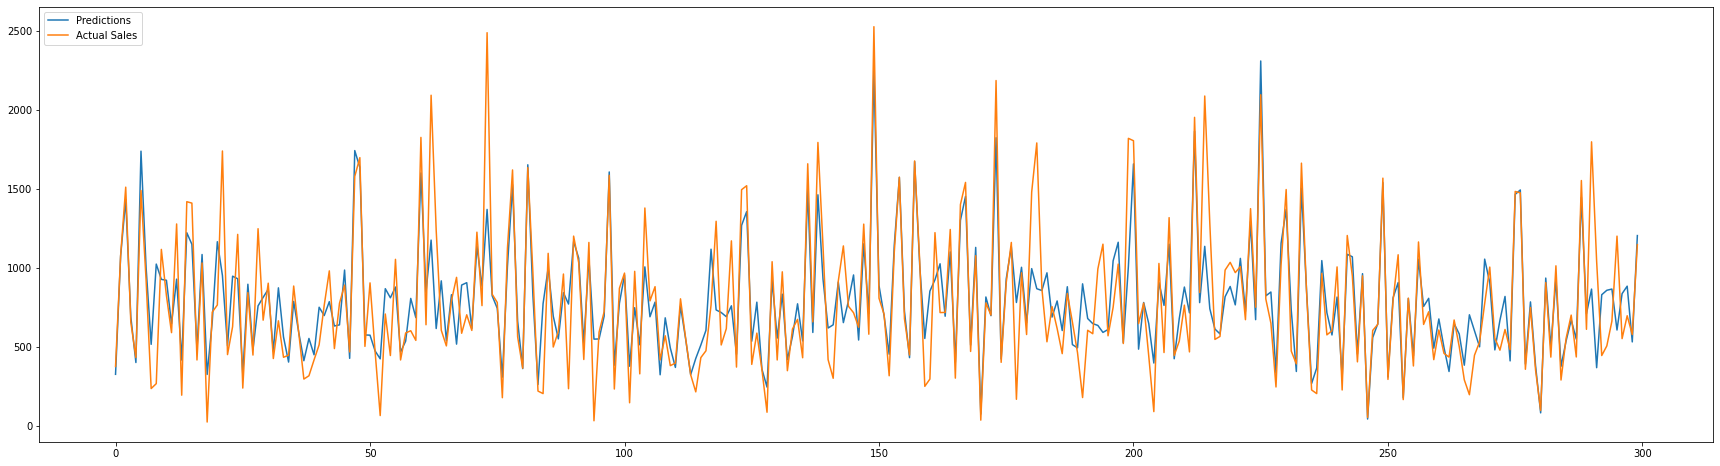

In [36]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[500:800], label='Predictions')
plt.plot(y_test[500:800], label='Actual Sales')
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()